In [2]:
from prototree.prototree import ProtoTree
from prototree.branch import Branch
from prototree.leaf import Leaf
from prototree.node import Node
import torch

import argparse
import torch.nn as nn
from torchvision.models import resnet50

# # Define the number of classes
# num_classes = 15  

# # Define the feature extraction network
# feature_net = resnet50(pretrained=True)

# # Define the arguments
# args = argparse.Namespace(depth=5, num_features=512, W1=10, H1=10, log_probabilities=None, disable_derivative_free_leaf_optim=False, kontschieder_normalization=False, kontschieder_train=False)
# # Initialize the ProtoTree
# model = ProtoTree(num_classes, feature_net, args)

In [3]:
# Load the model state dictionary
# model_state_dict = torch.load('/home/dhaval/prototree/runs/run_prototree/checkpoints/best_test_model/model_state.pth')  
# model.load_state_dict(model_state_dict)

# Load the optimizer state dictionary
# optimizer_state_dict = torch.load('/home/dhaval/prototree/runs/run_prototree/checkpoints/best_test_model/optimizer_state.pth')  
# optimizer.load_state_dict(optimizer_state_dict)

# Switch to evaluation mode
# model.eval()

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Normalize, Compose, Lambda
device = torch.device('cuda:{}'.format(torch.cuda.current_device()))

In [5]:
tree = torch.load('runs/run_prototree/checkpoints/best_test_model/model.pth', map_location=device)

In [6]:
tree

ProtoTree(
  (_root): Branch(
    (l): Branch(
      (l): Branch(
        (l): Branch(
          (l): Branch(
            (l): Branch(
              (l): Branch(
                (l): Branch(
                  (l): Branch(
                    (l): Leaf()
                    (r): Leaf()
                  )
                  (r): Branch(
                    (l): Leaf()
                    (r): Leaf()
                  )
                )
                (r): Branch(
                  (l): Branch(
                    (l): Leaf()
                    (r): Leaf()
                  )
                  (r): Branch(
                    (l): Leaf()
                    (r): Leaf()
                  )
                )
              )
              (r): Branch(
                (l): Branch(
                  (l): Branch(
                    (l): Leaf()
                    (r): Leaf()
                  )
                  (r): Branch(
                    (l): Leaf()
                    (r): Leaf()
  

In [7]:
# define transforms same as used in training

img_size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

normalize = transforms.Normalize(mean=mean, std=std)

transform_no_augment = transforms.Compose(
        [transforms.Resize(size=(img_size, img_size)), transforms.ToTensor(), normalize]
    )

In [12]:
torch.cuda.empty_cache()

test_dir = "./data/NIH_CHEST_XRAYS/dataset/test_full"

testset = torchvision.datasets.ImageFolder(test_dir, transform=transform_no_augment)
testloader = torch.utils.data.DataLoader(
        testset, batch_size=16, shuffle=False, pin_memory=device
    )

current = []
predictions = []
tree.eval()
for i, (xs, ys) in enumerate(testloader):
    xs, ys = xs.to(device), ys.to(device)

    out, test_info = tree.forward(xs, 'distributed')
    ys_pred = torch.argmax(out, dim=1)
    predictions.append(ys_pred)
    current.append(ys)


In [13]:
import numpy as np

concatenated_pred = torch.cat(predictions)
concatenated_current = torch.cat(current)

con_final_pred = concatenated_pred.cpu()
con_final_current = concatenated_current.cpu()

np_pred = con_final_pred .numpy()
np_current = con_final_current.numpy()

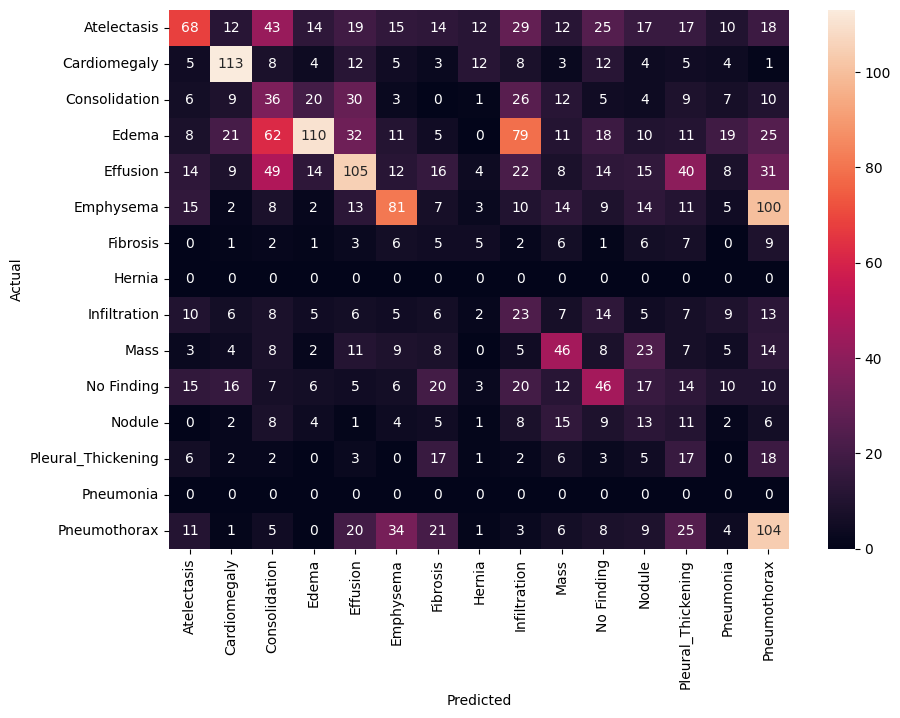

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

classes = testset.classes

cm = confusion_matrix(np_pred, np_current)

# Create a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()